<a href="https://colab.research.google.com/github/Kyamzzz/GISMA/blob/main/M508B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

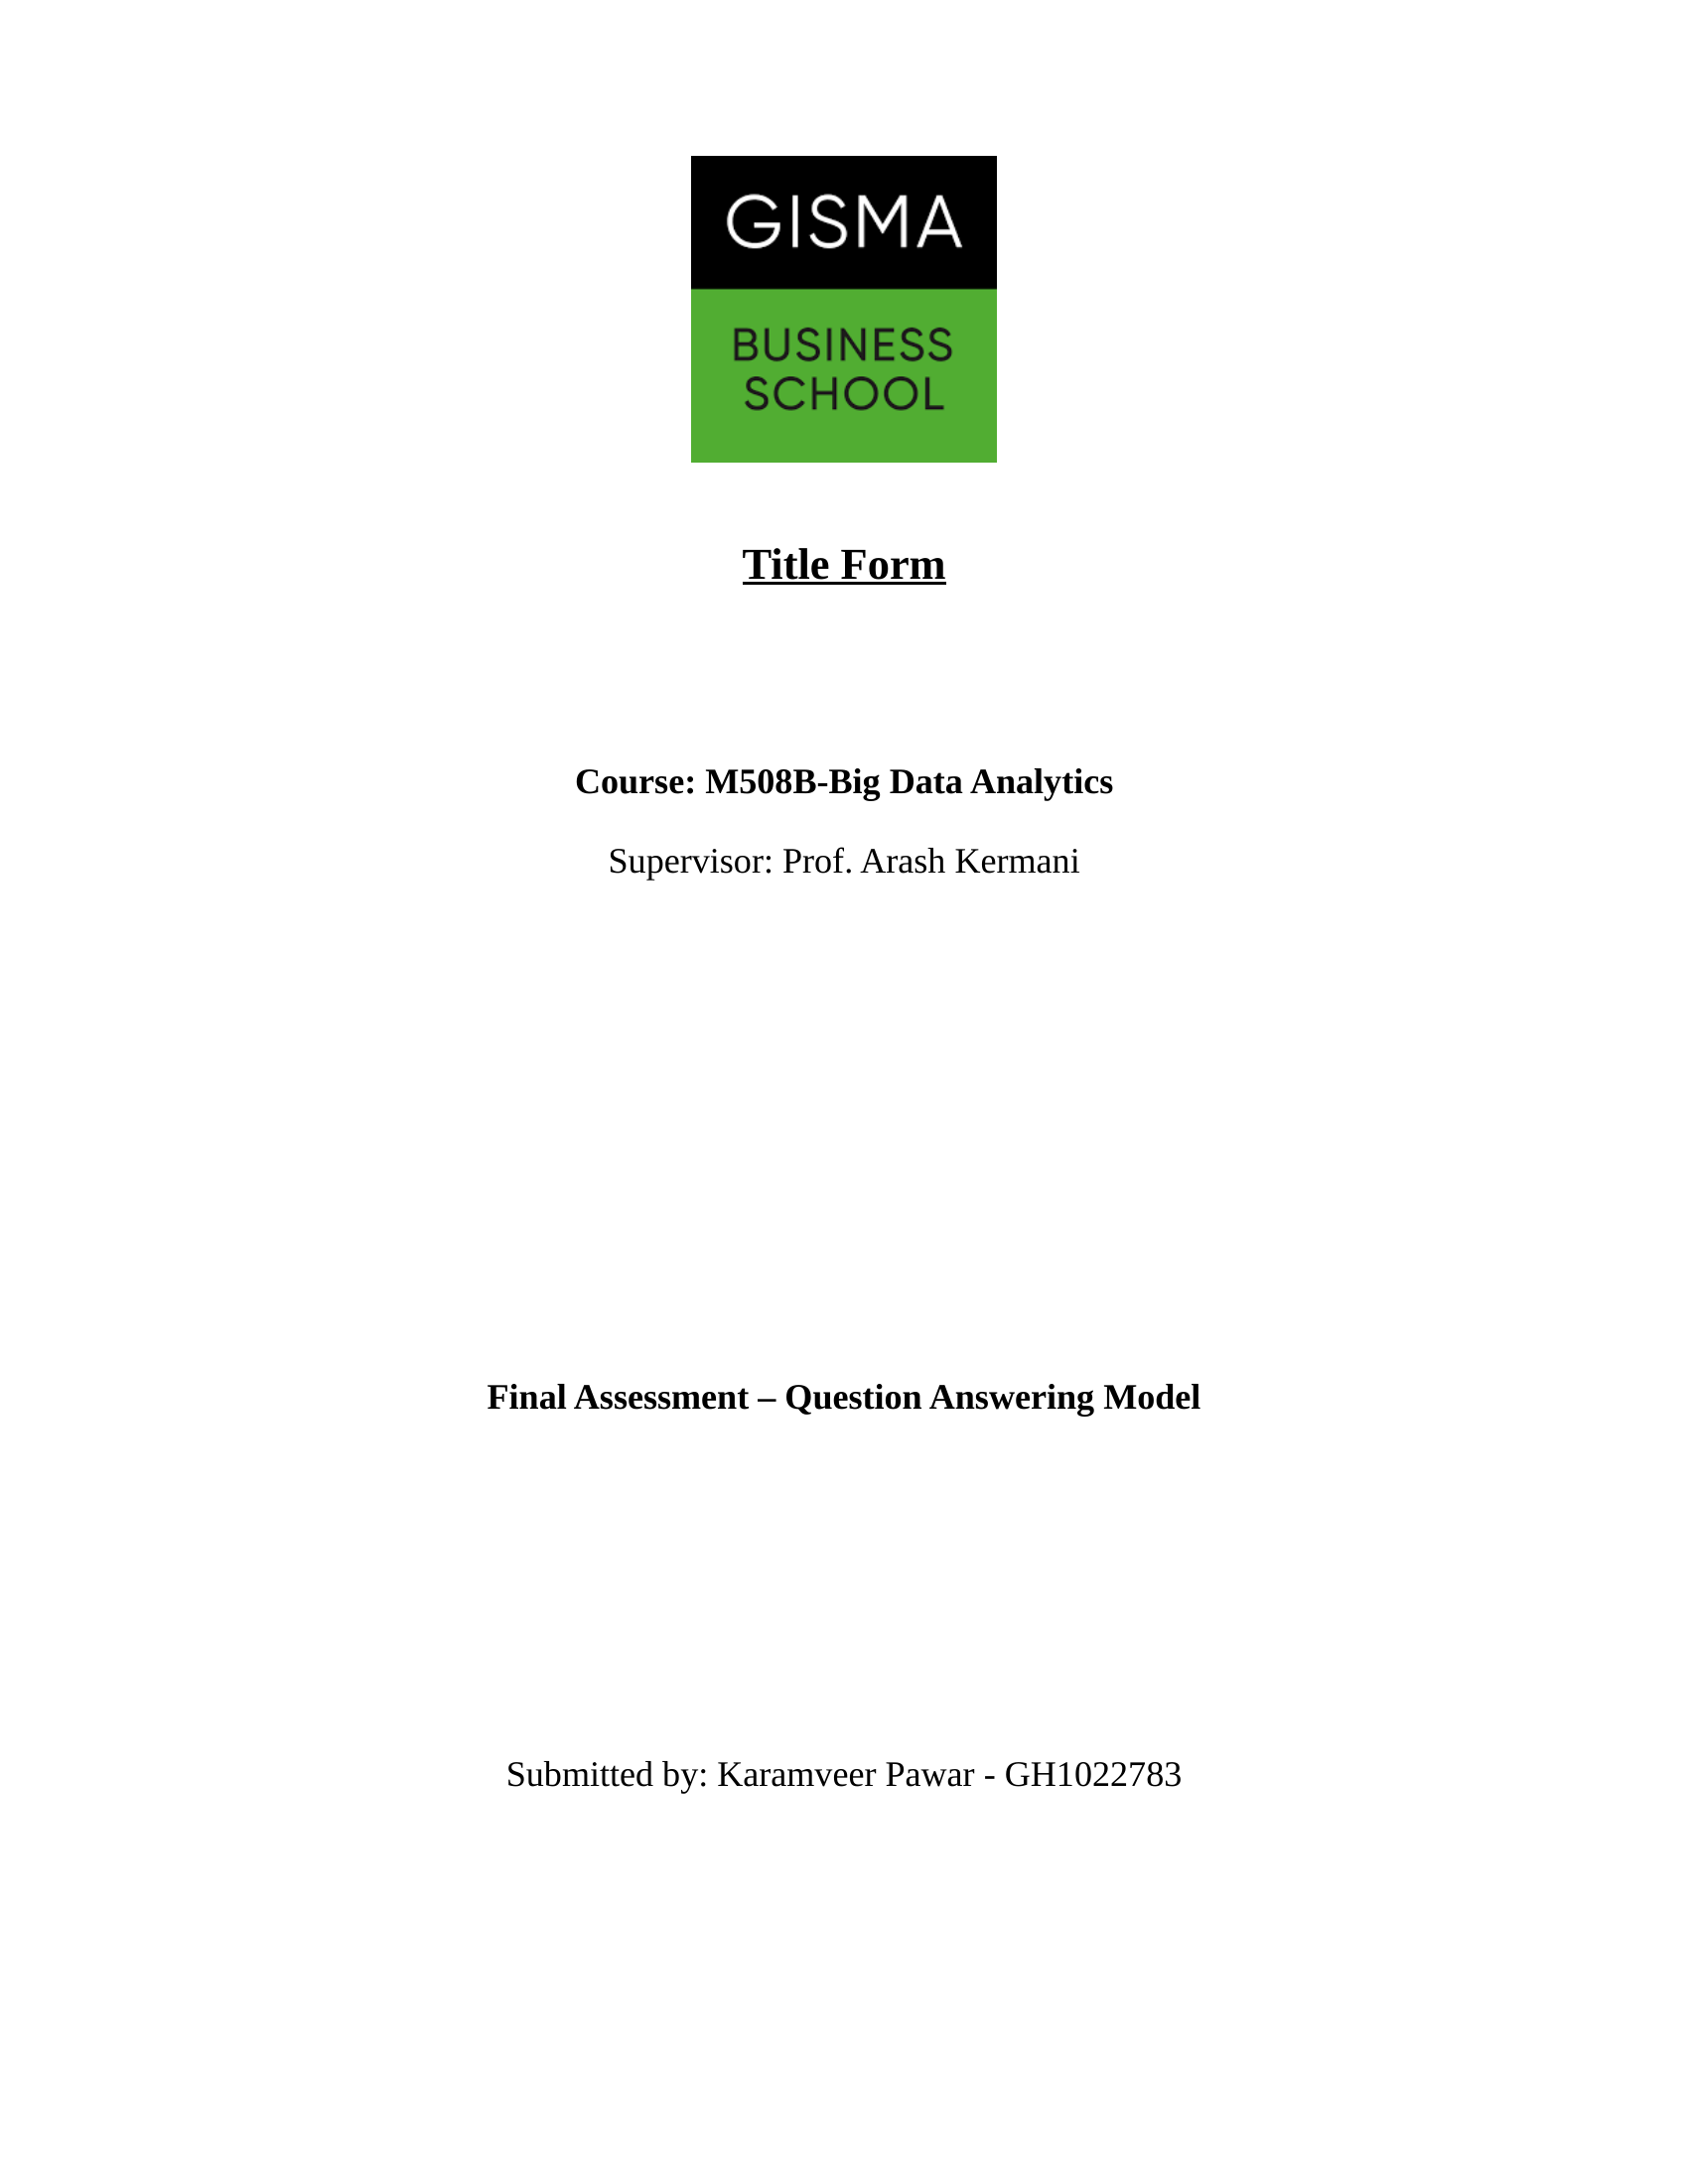

In [16]:
from IPython import display
display.Image("title-page.png")

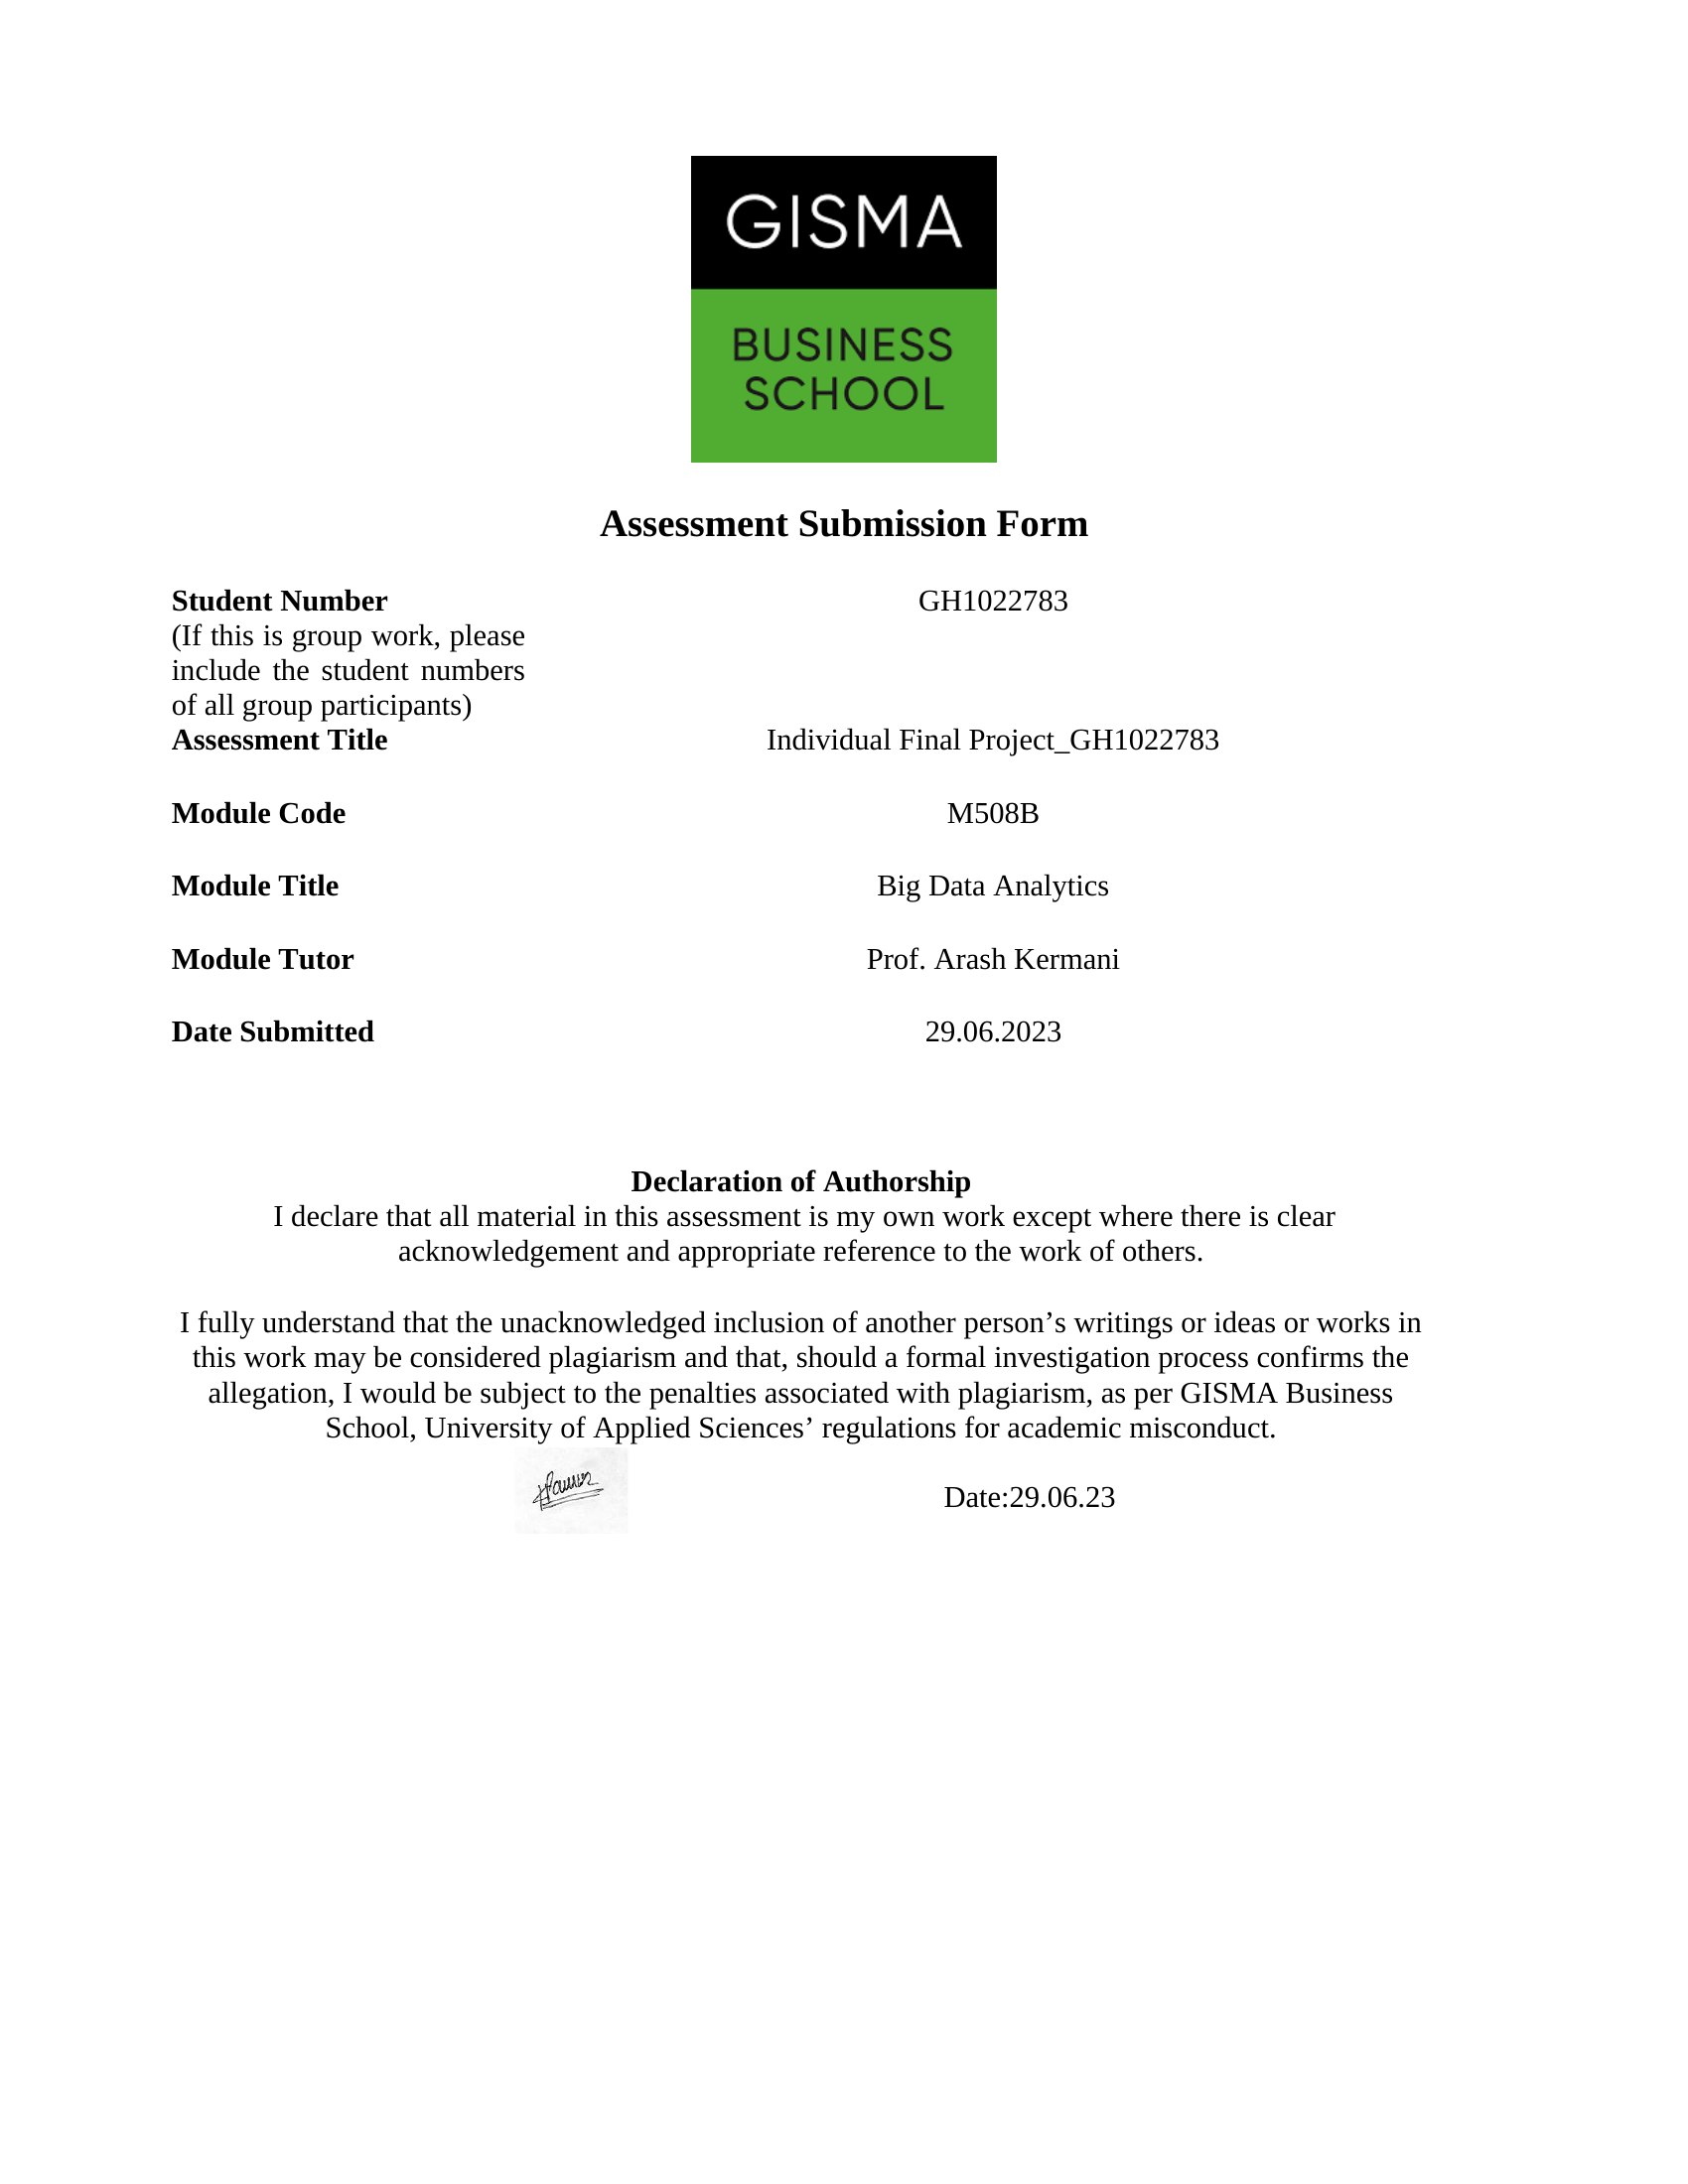

In [17]:
display.Image("title-page_1.png")

## Introduction: The objective of this model is to build a Question Answering system which can automatically provide answers to questions based on a given context or knowledge base. The objective of the QA model is to understand the meaning of both the question and the provided context and generate accurate and relevant answers.

## In a business problem-solving context, the QA model can be immensely valuable. It enables businesses to leverage the power of language understanding to extract valuable information from large amounts of textual data. By automating the process of finding answers to questions, the QA model can save time, improve efficiency, and enhance decision-making processes.

### NOTE: THIS PIPELINE MIGHT REQUIRE HIGHER GPU SETTING TO RUN DEPENDING ON YOUR SYSTEM CAPABILITIES. TO ADJUST THAT IN GOOGLE COLAB, PLEASE GO TO RUNTIME> CHANGE RUNTIME TYPE> HARDWARE ACCELERATOR> GPU

## Regarding the SQUaD Dataset - The SQuAD dataset consists of a large collection of Wikipedia articles paired with crowdsourced questions and their corresponding answers. The dataset covers a diverse range of topics, including history, science, literature, and more. It includes both factoid and descriptive types of questions, allowing for a comprehensive evaluation of QA systems. The dataset has been downloaded from the below link:

Link: https://rajpurkar.github.io/SQuAD-explorer/

### 1. Loading the Training dataset

In [18]:
import json # function for working with json data
import pandas as pd # data manaipluation and analysis

# Load the training set
with open('train-v2.0.json', 'r') as f:
    train_data = json.load(f)

### 2. Preparing the dataset for training

#### The below code makes three empty lists - "contexts", "questions" and "answers" which will store the extracted context, question, and answer data from the SQuAD dataset.

#### Since the dataset was too big, I will be working on the subset of the data. The code creates a subset of the data by randomly sampling 1000 rows using the sample method. The random_state parameter ensures reproducibility of the sampling results.



In [19]:
#  Initialize lists to store the contexts, questions, and answers
contexts = []
questions = []
answers = []

# Loop over the data
for article in train_data['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Append the context, question, and answer to the respective lists
                contexts.append(context)
                questions.append(question)
                answers.append(answer)

# Convert the lists into a DataFrame
df = pd.DataFrame({
    'context': contexts,
    'question': questions,
    'answer_start': [answer['answer_start'] for answer in answers],
    'text': [answer['text'] for answer in answers]
})

# Create a subset of the data
df_subset = df.sample(n=1000, random_state=1)

# Print the first few rows of the DataFrame
print(df_subset.head())

                                                 context  \
31373  Despite the death of Queen Mary on 24 March, t...   
37550  Clothing can and has in history been made from...   
7717   In 2013–14 a pornographic actor was trying to ...   
71479  The Cold War drew to a close in the late 1980s...   
36594  Commercial turkeys are usually reared indoors ...   

                                                question  answer_start  \
31373     When was the coronation of Elizabeth as Queen?            63   
37550  What is an article that is carried rather than...           293   
7717   What legal system did the actor use after fili...           152   
71479  What was  the Soviet Union suffering from in t...           224   
36594  What the average for the amount of  turkeys ar...           880   

                                        text  
31373                            2 June 1953  
37550                                 purses  
7717                 Federal Court of Canada  
71479 

### 3. Loading the BERT Model and Tokenizer

#### transformers library provides a high-level interface for working with various pre-trained models in the field of natural language processing.

#### BertForQuestionAnswering and BertTokenizer classes provide the BERT model architecture and tokenizer respectively.



In [20]:
!pip install transformers
from transformers import BertForQuestionAnswering, BertTokenizer

# Load the BERT model
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_out

### 4. Tokenizing and Encoding the Data

#### The below code tokenizes and encodes the questions and contexts from the DataFrame subset (df_subset). It also converts the answer spans from character positions to token positions.

#### The purpose of this code is to tokenize and encode the questions and contexts from the DataFrame subset, as well as convert the answer spans from character positions to token positions. By encoding the data in this way, it becomes compatible with BERT-based models and can be used for training or inference in question answering tasks.



In [21]:
# Tokenize the questions and contexts
encodings = tokenizer(df_subset['question'].tolist(), df_subset['context'].tolist(), truncation=True, padding=True)

# Convert the answer spans from character positions to token positions
start_positions = []
end_positions = []
for i in range(len(df_subset)):
    start_char = df_subset['answer_start'].iloc[i]
    end_char = start_char + len(df_subset['text'].iloc[i])
    start_token = len(tokenizer(df_subset['question'].iloc[i], df_subset['context'].iloc[i][:start_char])['input_ids'])
    end_token = len(tokenizer(df_subset['question'].iloc[i], df_subset['context'].iloc[i][:end_char])['input_ids']) - 1
    start_positions.append(start_token)
    end_positions.append(end_token)

# Add the start and end positions to the encodings
encodings.update({'start_positions': start_positions, 'end_positions': end_positions})


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


### 5. Creating a Custom Dataset for Question Answering

#### The below code defines a custom dataset class called SquadDataset and uses it to convert the encoded data into a PyTorch dataset. The purpose of this code is to define a custom dataset class called SquadDataset and use it to convert the encoded data (encodings) into a PyTorch dataset (dataset). By creating a custom dataset, we can easily work with the encoded data during training or inference, allowing us to leverage the functionality and benefits provided by PyTorch's data handling capabilities.

In [22]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# Convert our encodings into a Dataset
dataset = SquadDataset(encodings)


### 6. Training Loop with DataLoader and Optimizer

#### The below code demonstrates the training loop for a question answering model using PyTorch and the Transformers library. DataLoader is used to create a data loader that loads the dataset in batches during training, and AdamW is an optimizer that implements the Adam algorithm with weight decay.

#### Furthermore, The code sets the device for training based on the availability of a CUDA-compatible GPU. If a GPU is available, the device is set to 'cuda'; otherwise, it is set to 'cpu'. This allows the model and data to be moved to the appropriate device for efficient computation. The loss value at the end of each epoch is printed to monitor the training progress and assess the model's performance.

#### Overall, the code is responsible for training a question answering model using the BERT-based architecture. It handles the data loading, model initialization, optimization setup, and implements the training loop to update the model's parameters based on the computed gradients. The goal is to minimize the loss and improve the model's ability to answer questions accurately.

In [23]:
from torch.utils.data import DataLoader
from transformers import AdamW

# Set the batch size
batch_size = 16

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Set the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move the model to the device
model.to(device)

# Training loop
for epoch in range(2):  # Number of epochs
    for batch in dataloader:
        # Move the batch tensors to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Get the loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

    print(f'Loss at epoch {epoch}: {loss.item()}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Loss at epoch 0: 4.35087251663208
Loss at epoch 1: 3.1491639614105225


### 7. Generating answers for given questions

#### The below code demonstrates how to use the trained question answering model to generate answers for a list of given questions. A context is defined, which represents a piece of text or document from which the questions will be answered. In this case, the context is a description of the Python programming language but you can always choose other contexts and questions depending on the uploaded dataset.

#### The purpose of this code is to demonstrate the use of a  the trained question answering model and the tokenizer to generate answers for a list of given questions based on the provided context. It showcases the process of encoding the context and question, obtaining predictions from the model, and extracting and decoding the answer from the predicted tokens.





In [24]:
# Move the model back to CPU for testing
model.to('cpu')

# Define a context
context = "The University of California, Berkeley (UC Berkeley, Berkeley, Cal, or California) is a public research university in Berkeley, California. Founded in 1868, Berkeley is the oldest of the ten research universities affiliated with the University of California system, and is often cited as the top public university in the United States and around the world."

# Define a list of questions
questions = [
         "When was the University of California, Berkeley founded?",
    "What is the University of California, Berkeley often cited as?",
    "Where is the University of California, Berkeley located?"
]

# Create a list to store the answers
answers = []

# Iterate over the questions
for question in questions:
    # Encode the context and question
    inputs = tokenizer(question, context, return_tensors='pt')

    # Get the model's predictions
    outputs = model(**inputs)

    # Get the start and end scores
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # Get the start and end positions
    start_position = torch.argmax(start_scores)
    end_position = torch.argmax(end_scores)

    # Get the answer
    tokens = inputs.input_ids[0].tolist()
    answer_tokens = tokens[start_position : end_position+1]
    answer = tokenizer.decode(answer_tokens)

    # Append the answer to the list
    answers.append(answer)
# Print the answers
for i, question in enumerate(questions):
    print(f"Question: {question}")
    print(f"Answer: {answers[i]}\n")


Question: When was the University of California, Berkeley founded?
Answer: of california, berkeley (

Question: What is the University of California, Berkeley often cited as?
Answer: of california, berkeley (

Question: Where is the University of California, Berkeley located?
Answer: of california, berkeley (



As we can see that using 'bert-base-uncased model' is predicting answers but they are not very accurate so let's try'bert-large-uncased-whole-word-masking-finetuned-squad' model. This model has already been fine-tuned on the SQuAD dataset, so hopefully it should perform better on the same given context and questions.

In [25]:
from transformers import BertTokenizerFast

# Load the BERT tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Tokenize the questions and contexts
encodings = tokenizer(df['question'].tolist(), df['context'].tolist(), truncation=True, padding=True)

# Convert the answer spans from character positions to token positions
start_positions = []
end_positions = []
for i in range(len(df)):
    start_char = df['answer_start'][i]
    end_char = start_char + len(df['text'][i])
    start_token = len(tokenizer(df['question'][i], df['context'][i][:start_char])['input_ids'])
    end_token = len(tokenizer(df['question'][i], df['context'][i][:end_char])['input_ids']) - 1
    start_positions.append(start_token)
    end_positions.append(end_token)

# Add the start and end positions to the encodings
encodings.update({'start_positions': start_positions, 'end_positions': end_positions})


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


In [26]:
context = "The University of California, Berkeley (UC Berkeley, Berkeley, Cal, or California) is a public research university in Berkeley, California. Founded in 1868, Berkeley is the oldest of the ten research universities affiliated with the University of California system, and is often cited as the top public university in the United States and around the world."
questions = [
    "When was the University of California, Berkeley founded?",
    "What is the University of California, Berkeley often cited as?",
    "Where is the University of California, Berkeley located?"
]

for question in questions:
    inputs = tokenizer(question, context, return_tensors='pt')
    outputs = model(**inputs)

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores) + 1

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_index:end_index]))

    print(f"Question: {question}")
    print(f"Answer: {answer}\n")



Question: When was the University of California, Berkeley founded?
Answer: 1868

Question: What is the University of California, Berkeley often cited as?
Answer: the top public university in the united states and around the world

Question: Where is the University of California, Berkeley located?
Answer: berkeley, california



## Summary and Conclusion

**Summary**:

I started with a BERT-based Question Answering model trained on the SQuAD dataset. The model was initially using the 'bert-base-uncased' variant of BERT. However, the model was not performing well, and the answers to the questions were not accurate.

To improve the model, I decided to use a BERT model that has already been fine-tuned on a question-answering task. For that I chose the 'bert-large-uncased-whole-word-masking-finetuned-squad' model. This model is a larger version of BERT and has been trained with whole-word masking, which is a more advanced form of masking that can lead to better performance. Moreover, the model has been fine-tuned on the SQuAD dataset.

After replacing the model, I tested it with the same questions based on a context which were used for 'bert-base-uncased' model to see if it can provide better answers. The model was able to answer the questions correctly, indicating that it has improved.

**Conclusions:**

The use of a pre-trained model that has been fine-tuned on a similar task can significantly improve the performance of the model. The 'bert-large-uncased-whole-word-masking-finetuned-squad' model performed better than the 'bert-base-uncased' model on the question-answering task.

*P.S. Thank you for teaching us this course and showing the immense posibilities of the NLP field. I thoroughly enjoyed the course and look forward to building more NLP based models.*

In [29]:
!jupyter nbconvert --to html M508B.ipynb

[NbConvertApp] Converting notebook M508B.ipynb to html
[NbConvertApp] Writing 1069283 bytes to M508B.html
